In [1]:
import numpy as np
import ndio.remote.neurodata as neurodata
import ndio.ramon as ramon
import time
import ndio

start = time.time()

token = 'kasthuri2015_ramon_v4'
channel = 'neurons'
res = 3

In [2]:
'''
Identify available objects: 
1600 different neurons within this small region of mammalian brain (several billionths of the whole brain)
'''
nd = neurodata()

id_segment = nd.get_ramon_ids(token, channel, ramon_type=ramon.RAMONSegment)
id_neuron = nd.get_ramon_ids(token, channel, ramon_type=ramon.RAMONNeuron)
print 'Number of RAMON segments (unique objects) is: ' + str(len(id_segment))
print 'In the 3 volume cylinder we identified {} (RAMON) neurons'.format(len(id_neuron))


Number of RAMON segments (unique objects) is: 3945
In the 3 volume cylinder we identified 1907 (RAMON) neurons


In [3]:
# Retrieve metadata for all objects

# Get all segments
segAll = nd.get_ramon(token,channel,id_segment)

print '\ntime elapsed so far: ' + str(time.time()-start)



time elapsed so far: 246.337639093


In [4]:
# Sanity check

c = 0
for s in segAll:
    if s.kvpairs['is_spine'] == '1':
            c += 1
print c
print len(segAll)

1295
3945


In [5]:
# get all data in 3 cylinders
import numpy as np

# A priori known bounds for cylinders.  Alternatively we could sweep over entire volume - this is more efficient.

xbox = [173,449] #[694,1794]
ybox = [437, 615] #[1750, 2460]
zbox = [1004, 1379];
res = 5
# data are pre-masked
segments = nd.get_cutout(token, channel, xbox[0], xbox[1], ybox[0], ybox[1], zbox[0], zbox[1], resolution = res)

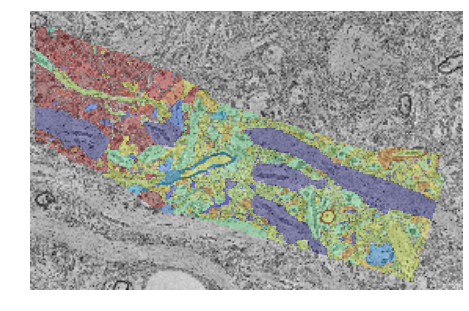

In [46]:
im = nd.get_cutout('kasthuri11cc', 'image', xbox[0], xbox[1], ybox[0], ybox[1], zbox[0], zbox[1], resolution = res)
import ndparse as ndp
%matplotlib inline  

ndp.plot(im, segments, slice =100, cmap1='gray', alpha=0.3)# for each object, loop through and relabel

In [7]:
'''
Identify Spines and Axons
'''

spine_id = []
spine_idx = []
axon_neurites = []
axon_neurons = []
axon_idx = []
c = 0

for x in segAll:
    #print x
    if x.segmentclass == 1:
        axon_neurites.append(int(x.id))
        axon_neurons.append(int(x.neuron))
        axon_idx.append(c)
    if x.kvpairs['is_spine'] == '1':
        spine_id.append(int(x.id))
        spine_idx.append(c)
    c += 1
print 'The total number of axon neurites in the three cylinders is: ' + str(len(axon_neurites))
print 'The total number of axons in the three cylinders is: ' + str(len(np.unique(axon_neurons)))

print 'The total number of spines in the three cylinders is: ' + str(len(spine_id))

The total number of axon neurites in the three cylinders is: 1766
The total number of axons in the three cylinders is: 1423
The total number of spines in the three cylinders is: 1295


In [8]:
# for each spinedil, add edge for each axon touch.neuron, [3, 3, 1]
# for each spine, add edge for each axon edge, which is spine.synapse.otherpartner.neuron
# save both graphs
# for each node in both graphs, add node attribute = spine or axon

import copy
segments2 = copy.copy(segments)
segments2 = np.ravel(segments)
t = time.time()

for x in range(0,len(spine_id)):
    segments2[segments2 == id_segment[spine_idx[x]]]
print str(time.time()-t)

31.7236480713


In [9]:
# TODO BETTER

# make spine mask
# make axon mask

spine_vol = np.zeros_like(segments)
for i in spine_id:
    #print i 
    spine_vol[segments == i] = i

axon_vol = np.zeros_like(segments)
for i in axon_neurites:
    #print i 
    axon_vol[segments == i] = i



In [10]:
spine_dil = copy.copy(spine_vol)

import mahotas
# dilate all spines
spine_dil = mahotas.dilate(spine_dil, Bc=np.ones([11,11,3]))

# remove all spines in original (to avoid overlap weirdness)
spine_dil[spine_vol > 0] = 0

In [11]:
# touch graph
# scale 5, epsilon, multiedge

import networkx as nx
graph_touch = nx.Graph()
axon_neurons = np.asarray(axon_neurons)

for i in spine_id:
    graph_touch.add_node(i)
    graph_touch[i]['type'] = 'spine'

for i in axon_neurons:
    graph_touch.add_node(i)
    graph_touch[i]['type'] = 'axon'

for s in spine_id:
    print str(s).zfill(4),

    val = axon_vol[s == spine_dil]
    val = np.unique(val)
    val = val[val > 0]
    
    for v in val:
        # TODO smarter way
        r = nd.get_ramon(token,'neurons',v)
        
        graph_touch.add_edge(s,r.neuron)
        #print v
        #print np.where(r.neuron == axon_neurons)

0133 0132 0131 0130 0137 0136 0135 0134 0139 0138 0025 0026 0027 0020 0021 0022 0023 0028 0029 0004 0120 0121 0122 0123 0124 0125 0126 0127 0128 0129 0059 0058 0057 0051 0115 0114 0117 0116 0111 0110 0113 0112 0080 0081 0119 0118 0003 0108 0109 0102 0103 0100 0101 0106 0107 0104 0105 0038 0033 0032 0031 0037 0036 0035 0034 0060 0061 0062 0064 0065 0099 0151 0150 0152 0047 0042 0040 0041 0146 0147 0144 0145 0142 0143 0140 0141 0148 0149 0077 0076 0079 0078 0211 0428 0289 0288 0281 0280 0283 0282 0285 0284 0287 0286 0457 0302 0298 0299 0296 0297 0294 0295 0375 0293 0290 0291 0196 0191 0190 0275 0276 0277 0278 0279 0429 0443 0364 0425 0424 0300 0441 0446 0445 0444 0292 0419 0438 0439 0437 0434 0435 0432 0433 0430 0431 0334 0452 0331 0455 0456 0332 0179 0178 0177 0176 0175 0174 0173 0172 0171 0170 0182 0183 0180 0181 0186 0187 0184 0185 0188 0189 0168 0169 0164 0165 0166 0167 0160 0161 0162 0163 0153 0155 0154 0157 0156 0159 0158 0327 0374 0203 0359 0669 0662 0661 0660 0696 0697 0818 0819 

In [12]:
print graph_touch.number_of_edges()
print graph_touch.number_of_nodes()


17039
2718


In [13]:
print '\ntime elapsed so far: ' + str(time.time()-start)



time elapsed so far: 2614.13832593


In [14]:
'''# Relabel everything
import copy
neurons = copy.copy(segments)

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    return [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value

for s in range(0,len(id_segment)):
    print s
    neurons[ismember(id_segment[s],segments)] = segAll[s].neuron
    '''
# synapse graph
#ndp.plot(spine_dil,slice=100)

#notaxon = np.setdiff1d(np.asarray(id_segment),np.asarray(axon_neurites))
#notspine = np.setdiff1d(np.asarray(id_segment),np.asarray(spine_id))    
#axon_vol = mahotas.labeled.remove_regions(segments, notaxon)
#s2 = mahotas.dilate(segments,np.ones([3,3,1]))


'# Relabel everything\nimport copy\nneurons = copy.copy(segments)\n\ndef ismember(a, b):\n    bind = {}\n    for i, elt in enumerate(b):\n        if elt not in bind:\n            bind[elt] = i\n    return [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value\n\nfor s in range(0,len(id_segment)):\n    print s\n    neurons[ismember(id_segment[s],segments)] = segAll[s].neuron\n    '

In [52]:
# Synapse graph
import networkx as nx
graph_synapse = nx.Graph()

for i in spine_id:
    graph_synapse.add_node(i)
    graph_synapse[i]['type'] = 'spine'

for i in axon_neurons:
    graph_synapse.add_node(i)
    graph_synapse[i]['type'] = 'axon'

for s in spine_id:
    print str(s).zfill(4),
    r = nd.get_ramon(token,'neurons',s)
    
    if len(r.synapses) > 0:
        syn = r.synapses[0]
        ss = nd.get_ramon(token, 'synapses', syn)
    
        axon = ss.kvpairs['presynaptic']
    
        if axon is not None:
            axon = int(axon)
            graph_synapse.add_edge(s,axon,weight=1)


 0133 0132 0131 0130 0137 0136 0135 0134 0139 0138 0025 0026 0027 0020 0021 0022 0023 0028 0029 0004 0120 0121 0122 0123 0124 0125 0126 0127 0128 0129 0059 0058 0057 0051 0115 0114 0117 0116 0111 0110 0113 0112 0080 0081 0119 0118 0003 0108 0109 0102 0103 0100 0101 0106 0107 0104 0105 0038 0033 0032 0031 0037 0036 0035 0034 0060 0061 0062 0064 0065 0099 0151 0150 0152 0047 0042 0040 0041 0146 0147 0144 0145 0142 0143 0140 0141 0148 0149 0077 0076 0079 0078 0211 0428 0289 0288 0281 0280 0283 0282 0285 0284 0287 0286 0457 0302 0298 0299 0296 0297 0294 0295 0375 0293 0290 0291 0196 0191 0190 0275 0276 0277 0278 0279 0429 0443 0364 0425 0424 0300 0441 0446 0445 0444 0292 0419 0438 0439 0437 0434 0435 0432 0433 0430 0431 0334 0452 0331 0455 0456 0332 0179 0178 0177 0176 0175 0174 0173 0172 0171 0170 0182 0183 0180 0181 0186 0187 0184 0185 0188 0189 0168 0169 0164 0165 0166 0167 0160 0161 0162 0163 0153 0155 0154 0157 0156 0159 0158 0327 0374 0203 0359 0669 0662 0661 0660 0696 0697 0818 0819

In [47]:
print graph_synapse.number_of_edges()
print graph_synapse.number_of_nodes()


2537
3359


In [53]:
nx.write_edgelist(graph_synapse, 'kasthuri2015_ramon_v4_graph_synapse.edgelist')
#nx.write_graphml(graph_synapse, 'kasthuri2015_ramon_v4_graph_synapse.graphml')
nx.write_edgelist(graph_touch, 'kasthuri2015_ramon_v4_graph_touch.edgelist')

AttributeError: 'str' object has no attribute 'items'

In [ ]:
print '\ntime elapsed so far: ' + str(time.time()-start)


In [42]:
len(r.synapses)

0

In [21]:
syn = r.synapses[0]


In [22]:
syn


1379